# Which seasonal windows and locations optimize safety—combining sunshine hours, wind-gust flags, and frost/heat indicators?

In [1]:
!pip install folium

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import month, avg, col, when, udf, expr, percentile_approx, substring
from pyspark.sql.types import StringType
import folium
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
from datetime import datetime

# Initialize Spark session
spark = SparkSession.builder.master('local[*]').appName('Climalyticsat').getOrCreate()

# Paths
csv_path = "/home/jovyan/work/climate_all_stations.csv"
meta_path = "/home/jovyan/work/stations_metadata.csv"

# Load data
climate_df = spark.read.option("header", True).option("inferSchema", True).csv(csv_path)
stations_meta = spark.read.option("header", True).option("inferSchema", True).csv(meta_path)
stations_meta = stations_meta.withColumnRenamed("id", "station_id") \
                             .withColumnRenamed("Höhe [m]", "altitude") \
                             .withColumnRenamed("Breite [°N]", "latitude") \
                             .withColumnRenamed("Länge [°E]", "longitude") \
                             .withColumnRenamed("Bundesland", "bundesland")

# Get current year and calculate cutoff year for 5 years back
current_year = datetime.now().year
cutoff_year = current_year - 5

# Extract year from 'date' column (string like "1970-01")
climate_df = climate_df.withColumn("year", substring(col("date"), 1, 4).cast("int"))

# Filter to last 5 years only
climate_df_filtered = climate_df.filter(col("year") >= cutoff_year)

# Join datasets
df_joined = climate_df_filtered.join(stations_meta, on="station_id")
station_count = df_joined.select("station_id").distinct().count()
print(f"Number of stations used: {station_count}")


# Season UDF
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"
season_udf = udf(get_season, StringType())

# Add month, season, elevation zone
df_season = df_joined.withColumn("month", month(col("date")))
df_season = df_season.withColumn("season", season_udf("month"))
df_season = df_season.withColumn(
    "elevation_zone",
    when(col("altitude") < 500, "0–499 m (Lowland)")
    .when(col("altitude") < 1000, "500–999 m (Upland)")
    .when(col("altitude") < 1500, "1000–1499 m (Lower Alps)")
    .when(col("altitude") < 2000, "1500–1999 m (Alpine)")
    .otherwise("2000+ m (High Alpine)")
)

# Aggregate climate metrics
agg_df = df_season.groupBy("station_id", "season", "bundesland", "elevation_zone") \
    .agg(
        avg("sh_manu_max").alias("avg_sunshine"),
        avg("tage_sh_manu_100").alias("wind_gust_freq"),
        avg("tage_frost").alias("frost_freq"),
        avg("tage_heit").alias("heat_freq"),
    )

# Raw safety score
agg_df = agg_df.withColumn(
    "safety_score_raw",
    col("avg_sunshine") - col("wind_gust_freq") - col("frost_freq") - col("heat_freq")
)

# Robust normalization
quantiles = agg_df.select(
    percentile_approx("safety_score_raw", [0.25, 0.5, 0.75]).alias("quantiles")
).collect()[0]["quantiles"]
q1, median, q3 = quantiles
iqr = q3 - q1

agg_df = agg_df.withColumn(
    "safety_score_robust",
    ((col("safety_score_raw") - expr(f"{median}")) / expr(f"{iqr}"))
)

# Clip and scale to 0–100
agg_df = agg_df.withColumn(
    "safety_score",
    when(col("safety_score_robust") < -2, -2)
    .when(col("safety_score_robust") > 2, 2)
    .otherwise(col("safety_score_robust"))
)
agg_df = agg_df.withColumn(
    "safety_score",
    ((col("safety_score") + 2) / 4) * 100
)

# Show top scores
agg_df.orderBy(col("safety_score").desc()).show(10, truncate=False)


Number of stations used: 1134
+----------+------+----------------+------------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------+
|station_id|season|bundesland      |elevation_zone          |avg_sunshine      |wind_gust_freq    |frost_freq        |heat_freq         |safety_score_raw  |safety_score_robust|safety_score|
+----------+------+----------------+------------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------+
|25        |Winter|Steiermark      |1000–1499 m (Lower Alps)|38.0              |0.0               |21.235294117647058|6.0               |10.764705882352942|2.5132743362831853 |100.0       |
|205       |Spring|Oberösterreich  |1500–1999 m (Alpine)    |85.9375           |5.3125            |14.375            |3.375             |62.875            |10.352876106194687 |100.0       |
|82        |Winter|S

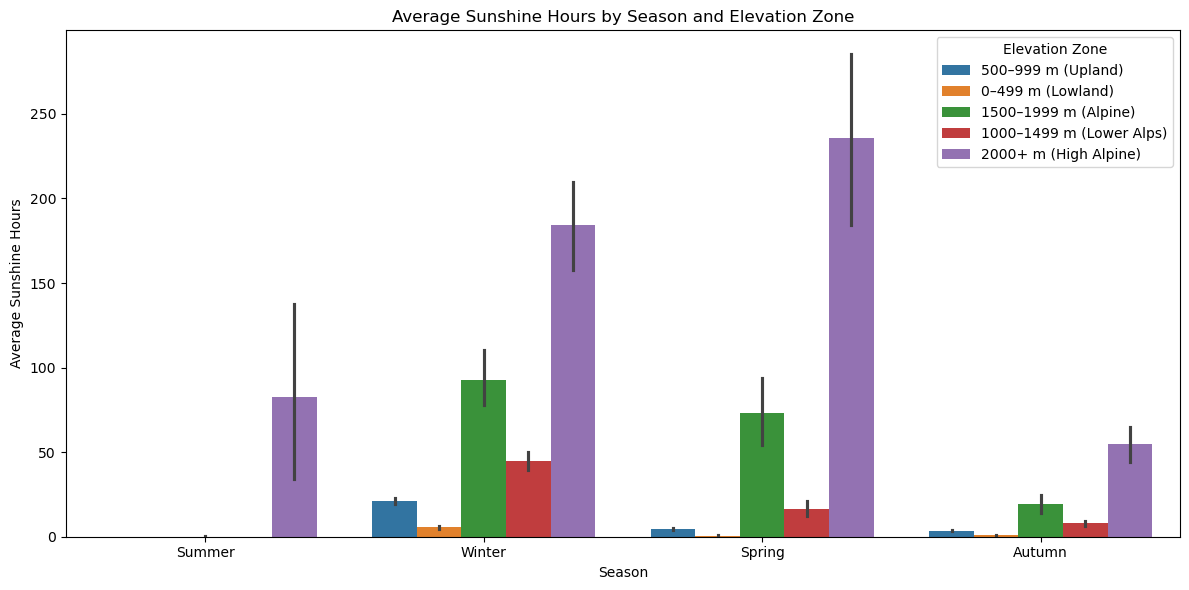

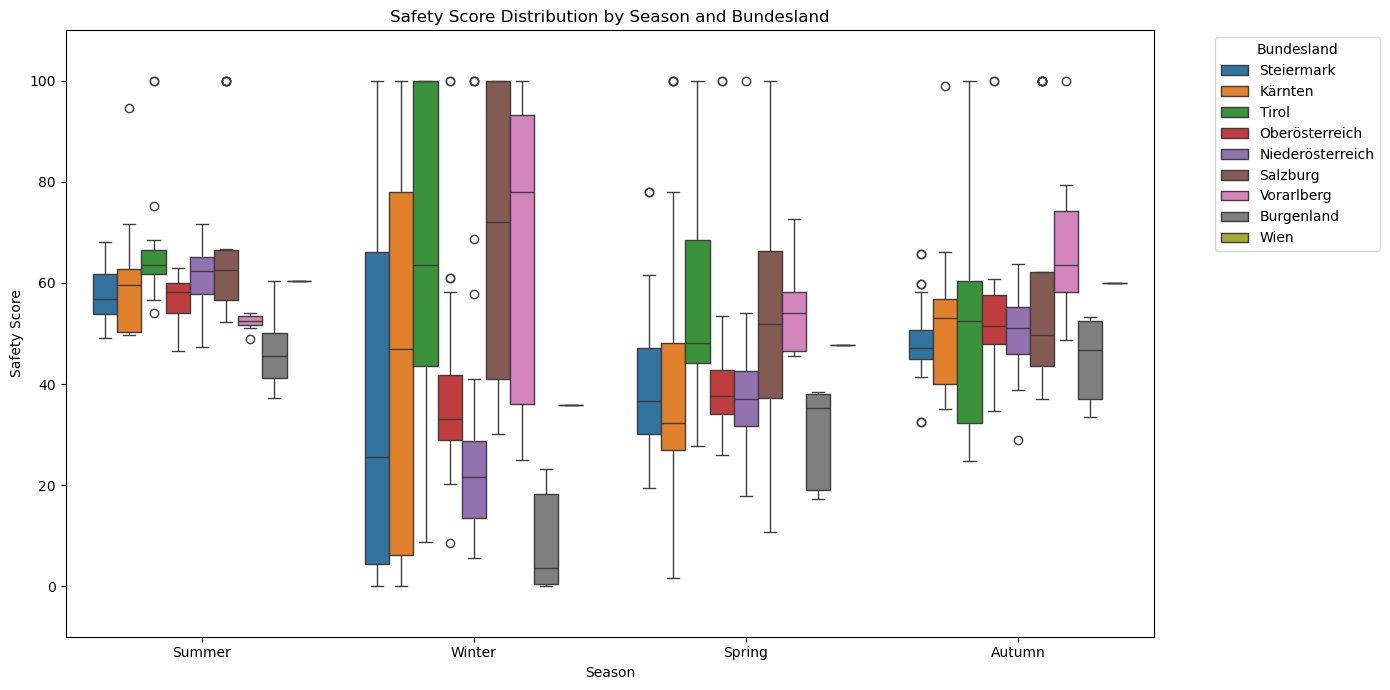

In [3]:
# Convert to pandas for plotting
agg_pd = agg_df.toPandas()
stations_meta_pd = stations_meta.select("station_id", "latitude", "longitude").toPandas()
agg_pd = agg_pd.merge(stations_meta_pd, on="station_id", how="left")

# Plot sunshine
plt.figure(figsize=(12,6))
sns.barplot(data=agg_pd, x="season", y="avg_sunshine", hue="elevation_zone")
plt.title("Average Sunshine Hours by Season and Elevation Zone")
plt.ylabel("Average Sunshine Hours")
plt.xlabel("Season")
plt.legend(title="Elevation Zone")
plt.tight_layout()
plt.show()

# Plot safety scores
plt.figure(figsize=(14,7))
sns.boxplot(data=agg_pd, x="season", y="safety_score", hue="bundesland")
plt.title("Safety Score Distribution by Season and Bundesland")
plt.ylabel("Safety Score")
plt.xlabel("Season")
plt.legend(title="Bundesland", bbox_to_anchor=(1.05,1), loc="upper left")
plt.ylim(-10, 110)
plt.tight_layout()
plt.show()

In [4]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import folium

# Prepare data
agg_mean_safety = agg_pd.groupby("station_id")[["safety_score"]].mean().reset_index()
agg_map_data = agg_mean_safety.merge(stations_meta_pd, on="station_id")

# Normalize scores for color mapping
norm = colors.Normalize(vmin=agg_map_data["safety_score"].min(), vmax=agg_map_data["safety_score"].max())
colormap = cm.get_cmap('RdYlGn')  # Red (low) to Green (high)

# Use a readable tile
m = folium.Map(location=[47.5, 13.5], zoom_start=7, tiles='CartoDB positron')

# Add markers
for _, row in agg_map_data.iterrows():
    score = row['safety_score']
    lat, lon = row['latitude'], row['longitude']
    
    if not np.isnan(score):
        color = colors.to_hex(colormap(norm(score)))
        folium.CircleMarker(
            location=[lat, lon],
            radius=6,
            popup=f"Station: {row['station_id']}\nAvg Safety Score: {score:.2f}",
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.8,
        ).add_to(m)

# Save and show map
map_path = "/home/jovyan/work/safety_map.html"
m.save(map_path)
display(m)
print(f"Map saved to {map_path}")


/tmp/ipykernel_6640/1833341042.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('RdYlGn')  # Red (low) to Green (high)


Map saved to /home/jovyan/work/safety_map.html
